In [1]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold
import pandas as pd
import operator
import kaggle
from kaggle.api.kaggle_api_extended import KaggleApi
import tensorflow as tf
import zipfile
import os
import PIL
import matplotlib.pyplot as plt
import numpy as np
import cv2
import time
import random
from stardist.models import StarDist2D
#from keras_unet_collection import models
import keras
import skimage
from sklearn.cluster import KMeans
import scipy
from PIL import Image
import statistics
import math
import copy
import scipy.stats as stats
import SimpleITK as Sitk
import numba
from numba import njit
import scipy.ndimage as ndimage
import scipy.ndimage as ndi
from skimage import measure
import multiprocessing
from multiprocessing import Pool
from aicsimageio import AICSImage
import matplotlib.pyplot as plt
#import numpy as np
import math
from PIL import Image
import cv2
import skimage
import sklearn
from skimage.filters import threshold_multiotsu
from numba import jit, cuda
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Input
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import GlobalAveragePooling2D
from keras import layers
from tensorflow.keras.applications import VGG16
import dill
from skimage.morphology import disk
import pickle
from matplotlib.colors import LinearSegmentedColormap
from aicsimageio import AICSImage
import multiprocessing
from sklearn.utils import class_weight
import tifffile

2026-01-16 16:43:37.296304: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1768581817.427691   83974 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1768581817.495584   83974 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1768581817.576329   83974 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1768581817.576399   83974 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1768581817.576407   83974 computation_placer.cc:177] computation placer alr

In [65]:
dill.dump_session("/scratch/c.c23115040/CancerSegmentation_Final.pkl")

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
def scaled(x):
    sc = (x - np.mean(x))/np.std(x)
    return sc

In [4]:
tf.experimental.numpy.experimental_enable_numpy_behavior()

In [5]:
lst = open("/scratch/c.c23115040/TMA Data/TMA Data/list.txt", "r")
lst = lst.read()
lst = lst.split("\n")
list2 = []
for i in range(len(lst)):
    if lst[i][12:15] == '0.6':
        list2.append(lst[i])
lst = list2    

list_ann = open("/scratch/c.c23115040/H&E_Annotated/list.txt", "r")
list_ann = list_ann.read()
list_ann = list_ann.split("\n")

list_char = []
list_char_ann = []

for i in range(len(lst)):
    list_char.append(lst[i][0:3])

for i in range(len(list_ann)):
    list_char_ann.append(list_ann[i][0:3])
    
labels = [i for i, item in enumerate(list_char) if item in set(list_char_ann)]

lst = operator.itemgetter(*labels)(lst)

In [6]:
lst2 = open("/scratch/c.c23115040/AMW/list.txt", "r")
lst2 = lst2.read()
lst2 = lst2.split("\n")

list_ann2 = open("/scratch/c.c23115040/H&E_Annotated2/list.txt", "r")
list_ann2 = list_ann2.read()
list_ann2 = list_ann2.split("\n")

list_char2 = []
list_char_ann2 = []

for i in range(len(lst2)):
    list_char2.append(lst2[i][12:14])

for i in range(len(list_ann2)):
    list_char_ann2.append(list_ann2[i][4:6])
    
labels2 = [i for i, item in enumerate(list_char2) if item in set(list_char_ann2)]

lst2 = operator.itemgetter(*labels2)(lst2)

In [7]:
lst3 = open("/scratch/c.c23115040/WCB_Sequential/list.txt", "r")
lst3 = lst3.read()
lst3 = lst3.split("\n")

list_ann3 = open("/scratch/c.c23115040/WCB_Sequential_Annotated/list.txt", "r")
list_ann3 = list_ann3.read()
list_ann3 = list_ann3.split("\n")

list_char3 = []
list_char_ann3 = []

for i in range(len(lst3)):
    list_char3.append(lst3[i][7:10])

for i in range(len(list_ann3)):
    list_char_ann3.append(list_ann3[i][7:10])
    
labels3 = [i for i, item in enumerate(list_char3) if item in set(list_char_ann3)]

lst3 = operator.itemgetter(*labels3)(lst3)

In [8]:
patient_list = pd.read_excel('patient_wise_list.xlsx', header = None)
patient_list1 = np.asarray(patient_list.iloc[:,0])
patient_list2 = np.asarray(patient_list.iloc[:,1], dtype = 'str')
patient_list3 = np.asarray(patient_list.iloc[:,2])
patient_list3 = patient_list3 - 1

In [9]:
epithelials = np.load("/home/c.c23115040/epithelials.npy", allow_pickle=True)
epithelials = operator.itemgetter(*labels)(epithelials)

In [10]:
epithelials2 = np.load("/home/c.c23115040/epithelials2.npy", allow_pickle=True)
epithelials2 = operator.itemgetter(*labels2)(epithelials2)

In [11]:
epithelials3 = np.load("/home/c.c23115040/epithelials3.npy", allow_pickle=True)
epithelials3 = operator.itemgetter(*labels3)(epithelials3)

In [12]:
full_masks = np.load("/home/c.c23115040/full_masks.npy", allow_pickle=True)

In [13]:
full_masks2 = np.load("/home/c.c23115040/full_masks2.npy", allow_pickle=True)

In [14]:
full_masks3 = np.load("/home/c.c23115040/full_masks3.npy", allow_pickle=True)

In [15]:
sz = 356
cr = int(np.floor(4095/sz))

for i in range(len(epithelials)):
    full_masks[i][epithelials[i] == 0] = 0
    
full_masks_resized = []

for k in range(len(full_masks)):
    full = np.zeros((cr, cr))
    for i in range(cr):
        for j in range(cr):
            distr = full_masks[k][sz*i:(sz*i+sz), sz*j:(sz*j+sz)].flatten().astype(int)
            distr2 = distr[distr != 0].copy()
            if len(distr2) == 0:
                full[i, j] = 0
            else:
                mx = np.argmax(np.bincount(distr2))
                if (np.bincount(distr2)[mx]/sum(np.bincount(distr2))) > 0.75 and (sum(np.bincount(distr2))/(sz*sz)) > 0.15:
                    full[i, j] = mx
                else:
                    full[i, j] = 0
    full_masks_resized.append(full)        

In [16]:
sz = 471
cr = int(np.floor(5119/sz))

for i in range(len(epithelials2)):
    full_masks2[i][epithelials2[i] == 0] = 0

for k in range(len(full_masks2)):
    full = np.zeros((cr, cr))
    for i in range(cr):
        for j in range(cr):
            distr = full_masks2[k][sz*i:(sz*i+sz), sz*j:(sz*j+sz)].flatten().astype(int)
            distr2 = distr[distr != 0].copy()
            if len(distr2) == 0:
                full[i, j] = 0
            else:
                mx = np.argmax(np.bincount(distr2))
                if (np.bincount(distr2)[mx]/sum(np.bincount(distr2))) > 0.75 and (sum(np.bincount(distr2))/(sz*sz)) > 0.15:
                    full[i, j] = mx
                else:
                    full[i, j] = 0
    full_masks_resized.append(full)        

In [17]:
sz = 471
cr = int(np.floor(2047/sz))

for i in range(len(epithelials3)):
    full_masks3[i][epithelials3[i] == 0] = 0

for k in range(len(full_masks3)):
    full = np.zeros((cr, cr))
    for i in range(cr):
        for j in range(cr):
            c_x = int(i - (cr/2))
            c_y = int(j - (cr/2))
            i_x = int(2047/2 + c_x*sz)
            f_x = int(2047/2 + (c_x+1)*sz)
            i_y = int(2047/2 + c_y*sz)
            f_y = int(2047/2 + (c_y+1)*sz)
            distr = full_masks3[k][i_x:f_x, i_y:f_y].flatten().astype(int)
            distr2 = distr[distr != 0].copy()
            if len(distr2) == 0:
                full[i, j] = 0
            else:
                mx = np.argmax(np.bincount(distr2))
                if (np.bincount(distr2)[mx]/sum(np.bincount(distr2))) > 0.75 and (sum(np.bincount(distr2))/(sz*sz)) > 0.15:
                    full[i, j] = mx
                else:
                    full[i, j] = 0
    full_masks_resized.append(full)        

In [18]:
DRAQ5_input = []
Eosin_input = []
classif = []
masks_segm = []
batch = []

sz = 356
cr = int(np.floor(4095/sz))

for k in range(len(lst)):
    img = cv2.imread("/scratch/c.c23115040/TMA Data/TMA Data/" + lst[k] + "_DRAQ5.tiff", cv2.IMREAD_UNCHANGED)
    DRAQ5 = img
    DRAQ5 = 4095*skimage.exposure.equalize_adapthist(DRAQ5, nbins = 4095)
    img = cv2.imread("/scratch/c.c23115040/TMA Data/TMA Data/" + lst[k] + "_Eosin.tiff", cv2.IMREAD_UNCHANGED)
    Eosin = img
    Eosin = 4095*skimage.exposure.equalize_adapthist(Eosin, nbins = 4095)
    mask_gleason = full_masks_resized[k]
    mask_gleason2 = full_masks[k]

    DRAQ5_crop = np.zeros((cr, cr, sz, sz, 1))
    Eosin_crop = np.zeros((cr, cr, sz, sz, 1))
    masks_crop = np.zeros((cr, cr, sz, sz, 1))
    for i in range(cr):
        for j in range(cr):
            DRAQ5_crop[i, j, :, :, 0] = DRAQ5[sz*i:(sz*i+sz), sz*j:(sz*j+sz)]
            Eosin_crop[i, j, :, :, 0] = Eosin[sz*i:(sz*i+sz), sz*j:(sz*j+sz)]
            masks_crop[i, j, :, :, 0] = mask_gleason2[sz*i:(sz*i+sz), sz*j:(sz*j+sz), 0]
            
    for i in range(cr):
        for j in range(cr):
            mask = mask_gleason[i,j].copy()
            if mask == 0:
                continue
            roi_DRAQ5 = DRAQ5_crop[i, j, :, :, 0].copy()
            roi_Eosin = Eosin_crop[i, j, :, :, 0].copy()
            roi_mask =  masks_crop[i, j, :, :, 0].copy()
            roi_DRAQ5 = cv2.resize(roi_DRAQ5, (256,256), fx=0, fy=0, interpolation = cv2.INTER_NEAREST)
            roi_Eosin = cv2.resize(roi_Eosin, (256,256), fx=0, fy=0, interpolation = cv2.INTER_NEAREST)
            roi_mask = cv2.resize(roi_mask, (256,256), fx=0, fy=0, interpolation = cv2.INTER_NEAREST)
            roi_DRAQ5 = scaled(roi_DRAQ5)
            roi_Eosin = scaled(roi_Eosin)
            roi_mask = roi_mask.astype(np.uint8)
            DRAQ5_input.append(roi_DRAQ5)
            Eosin_input.append(roi_Eosin)
            masks_segm.append(roi_mask)
            classif.append(mask)
            batch.append(patient_list3[np.where(patient_list1 == lst[k][0:3])[0][0]])

In [19]:
sz = 471
cr = int(np.floor(5119/sz))

for k in range(len(lst2)):
    img = cv2.imread("/scratch/c.c23115040/AMW/" + lst2[k] + "DRAQ5.tiff", cv2.IMREAD_UNCHANGED)
    DRAQ5 = img
    DRAQ5 = 4095*skimage.exposure.equalize_adapthist(DRAQ5, nbins = 4095)
    img = cv2.imread("/scratch/c.c23115040/AMW/" + lst2[k] + "Eosin.tiff", cv2.IMREAD_UNCHANGED)
    Eosin = img
    Eosin = 4095*skimage.exposure.equalize_adapthist(Eosin, nbins = 4095)
    mask_gleason = full_masks_resized[len(lst) + k]
    mask_gleason2 = full_masks2[k]

    DRAQ5_crop = np.zeros((cr, cr, sz, sz, 1))
    Eosin_crop = np.zeros((cr, cr, sz, sz, 1))
    masks_crop = np.zeros((cr, cr, sz, sz, 1))
    for i in range(cr):
        for j in range(cr):
            DRAQ5_crop[i, j, :, :, 0] = DRAQ5[sz*i:(sz*i+sz), sz*j:(sz*j+sz)]
            Eosin_crop[i, j, :, :, 0] = Eosin[sz*i:(sz*i+sz), sz*j:(sz*j+sz)]
            masks_crop[i, j, :, :, 0] = mask_gleason2[sz*i:(sz*i+sz), sz*j:(sz*j+sz), 0]
            
    for i in range(cr):
        for j in range(cr):
            mask = mask_gleason[i,j].copy()
            if mask == 0:
                continue
            roi_DRAQ5 = DRAQ5_crop[i, j, :, :, 0].copy()
            roi_Eosin = Eosin_crop[i, j, :, :, 0].copy()
            roi_mask =  masks_crop[i, j, :, :, 0].copy()
            roi_DRAQ5 = cv2.resize(roi_DRAQ5, (256,256), fx=0, fy=0, interpolation = cv2.INTER_NEAREST)
            roi_Eosin = cv2.resize(roi_Eosin, (256,256), fx=0, fy=0, interpolation = cv2.INTER_NEAREST)
            roi_mask = cv2.resize(roi_mask, (256,256), fx=0, fy=0, interpolation = cv2.INTER_NEAREST)
            roi_DRAQ5 = scaled(roi_DRAQ5)
            roi_Eosin = scaled(roi_Eosin)
            DRAQ5_input.append(roi_DRAQ5)
            Eosin_input.append(roi_Eosin)
            masks_segm.append(roi_mask)
            classif.append(mask)
            batch.append(patient_list3[np.where(patient_list2 == lst2[k][12:14])[0][0]])

In [19]:
sz = 471
cr = int(np.floor(2047/sz))

for k in range(len(lst3)):
    img = cv2.imread("/scratch/c.c23115040/WCB_Sequential/" + lst3[k] + "DRAQ5.tiff", cv2.IMREAD_UNCHANGED)
    DRAQ5 = img
    DRAQ5 = 4095*skimage.exposure.equalize_adapthist(DRAQ5, nbins = 4095)
    img = cv2.imread("/scratch/c.c23115040/WCB_Sequential/" + lst3[k] + "Eosin.tiff", cv2.IMREAD_UNCHANGED)
    Eosin = img
    Eosin = 4095*skimage.exposure.equalize_adapthist(Eosin, nbins = 4095)
    mask_gleason = full_masks_resized[len(lst) + len(lst2) + k]
    mask_gleason2 = full_masks3[k]

    DRAQ5_crop = np.zeros((cr, cr, sz, sz, 1))
    Eosin_crop = np.zeros((cr, cr, sz, sz, 1))
    masks_crop = np.zeros((cr, cr, sz, sz, 1))
    for i in range(cr):
        for j in range(cr):
            c_x = int(i - (cr/2))
            c_y = int(j - (cr/2))
            i_x = int(2047/2 + c_x*sz)
            f_x = int(2047/2 + (c_x+1)*sz)
            i_y = int(2047/2 + c_y*sz)
            f_y = int(2047/2 + (c_y+1)*sz)
            DRAQ5_crop[i, j, :, :, 0] = DRAQ5[i_x:f_x, i_y:f_y]
            Eosin_crop[i, j, :, :, 0] = Eosin[i_x:f_x, i_y:f_y]
            masks_crop[i, j, :, :, 0] = mask_gleason2[i_x:f_x, i_y:f_y, 0]
            
    for i in range(cr):
        for j in range(cr):
            mask = mask_gleason[i,j].copy()
            if mask == 0:
                continue
            roi_DRAQ5 = DRAQ5_crop[i, j, :, :, 0].copy()
            roi_Eosin = Eosin_crop[i, j, :, :, 0].copy()
            roi_mask =  masks_crop[i, j, :, :, 0].copy()
            roi_DRAQ5 = cv2.resize(roi_DRAQ5, (256,256), fx=0, fy=0, interpolation = cv2.INTER_NEAREST)
            roi_Eosin = cv2.resize(roi_Eosin, (256,256), fx=0, fy=0, interpolation = cv2.INTER_NEAREST)
            roi_mask = cv2.resize(roi_mask, (256,256), fx=0, fy=0, interpolation = cv2.INTER_NEAREST)
            roi_DRAQ5 = scaled(roi_DRAQ5)
            roi_Eosin = scaled(roi_Eosin)
            DRAQ5_input.append(roi_DRAQ5)
            Eosin_input.append(roi_Eosin)
            masks_segm.append(roi_mask)
            classif.append(mask)
            batch.append(49 + k)

In [20]:
classif = np.array(classif)

In [21]:
batch = np.array(batch)

In [22]:
healthy = np.where(classif == 1)[0]
gleason3 = np.where(classif == 2)[0]
gleason4 = np.where(classif == 3)[0]
cribriform = np.where(classif == 4)[0]
glomeruloid = np.where(classif == 5)[0]
gleason5 = np.where(classif == 6)[0]
gleason4_merg = np.concatenate((gleason4, cribriform, glomeruloid))
gleason_disease = np.concatenate((gleason3, gleason4, cribriform, glomeruloid, gleason5))

In [23]:
batch_h = batch[classif == 1]
batch_3 = batch[classif == 2]
batch_4 = batch[classif == 3]
batch_c = batch[classif == 4]
batch_g = batch[classif == 5]
batch_5 = batch[classif == 6]
batch_m = np.concatenate((batch_4, batch_c, batch_g))
batch_d = np.concatenate((batch_3, batch_4, batch_c, batch_g, batch_5))

In [24]:
h = []
ds = []
#d = []
for k in range(49+len(lst3)):
    h.append(sum(classif[batch == k] == 1))
    ds.append(sum(classif[batch == k] > 1))
    #d.append(sum(sum(full_masks_resized[k] > 2)))
    
d = {'h': h, 'ds': ds}

In [25]:
df = np.asarray(pd.DataFrame(data=d))

In [26]:
m = []
qq = []
for q in range(1000):
    li = list(range(49+len(lst3)))
    random.shuffle(li)
    qte = []
    for i in range(0, 49+len(lst3), (49+len(lst3))//5):
        qte.append(li[i:i+25])
    f1 = (sum(df[qte[0],0]))/(sum(df[qte[0],1]))
    f2 = (sum(df[qte[1],0]))/(sum(df[qte[1],1]))
    f3 = (sum(df[qte[2],0]))/(sum(df[qte[2],1]))
    f4 = (sum(df[qte[3],0]))/(sum(df[qte[3],1]))
    f5 = (sum(df[qte[4],0]))/(sum(df[qte[4],1])) 
    try:
        m.append(sklearn.metrics.mean_squared_error([f1, f2, f3, f4, f5], [1, 1, 1, 1, 1]))
    except:
        continue
    qq.append(qte)

In [27]:
qte = qq[np.argmin(m)]

In [28]:
qte 

[[77,
  98,
  44,
  103,
  116,
  21,
  122,
  2,
  124,
  75,
  121,
  57,
  78,
  89,
  60,
  9,
  48,
  61,
  68,
  88,
  55,
  8,
  126,
  82,
  93],
 [38,
  100,
  81,
  16,
  36,
  107,
  85,
  73,
  67,
  29,
  42,
  37,
  110,
  92,
  20,
  19,
  5,
  1,
  32,
  50,
  59,
  0,
  39,
  123,
  13],
 [18,
  51,
  104,
  41,
  71,
  3,
  106,
  49,
  63,
  118,
  54,
  15,
  46,
  66,
  86,
  105,
  74,
  7,
  26,
  24,
  4,
  45,
  58,
  72,
  90],
 [40,
  76,
  28,
  10,
  22,
  27,
  11,
  114,
  95,
  83,
  87,
  65,
  12,
  64,
  109,
  25,
  14,
  43,
  79,
  23,
  120,
  31,
  97,
  30,
  80],
 [35,
  52,
  111,
  34,
  56,
  53,
  84,
  96,
  47,
  108,
  62,
  99,
  119,
  6,
  91,
  102,
  94,
  112,
  101,
  115,
  17,
  69,
  125,
  33,
  117],
 [70, 113]]

In [29]:
qte[4].append(qte[5][0])
qte[4].append(qte[5][1])
qte = qte[0:5]

In [30]:
qte

[[77,
  98,
  44,
  103,
  116,
  21,
  122,
  2,
  124,
  75,
  121,
  57,
  78,
  89,
  60,
  9,
  48,
  61,
  68,
  88,
  55,
  8,
  126,
  82,
  93],
 [38,
  100,
  81,
  16,
  36,
  107,
  85,
  73,
  67,
  29,
  42,
  37,
  110,
  92,
  20,
  19,
  5,
  1,
  32,
  50,
  59,
  0,
  39,
  123,
  13],
 [18,
  51,
  104,
  41,
  71,
  3,
  106,
  49,
  63,
  118,
  54,
  15,
  46,
  66,
  86,
  105,
  74,
  7,
  26,
  24,
  4,
  45,
  58,
  72,
  90],
 [40,
  76,
  28,
  10,
  22,
  27,
  11,
  114,
  95,
  83,
  87,
  65,
  12,
  64,
  109,
  25,
  14,
  43,
  79,
  23,
  120,
  31,
  97,
  30,
  80],
 [35,
  52,
  111,
  34,
  56,
  53,
  84,
  96,
  47,
  108,
  62,
  99,
  119,
  6,
  91,
  102,
  94,
  112,
  101,
  115,
  17,
  69,
  125,
  33,
  117,
  70,
  113]]

In [31]:
classif2 = np.concatenate((np.full((healthy.shape[0], 1), 0), np.full((gleason_disease.shape[0], 1), 1)))

In [32]:
data = np.concatenate((healthy, gleason_disease))

In [33]:
batch2 = np.concatenate((batch_h, batch_d))

In [34]:
data = data[:, np.newaxis]

In [35]:
data = np.concatenate((data, classif2, batch2[:, np.newaxis]), axis = 1)
np.random.shuffle(data)

In [36]:
classif3 = data[:, 1]
batch3 = data[:, 2]

In [57]:
#acc = []
#acc2 = []
#acc3 = []
#listtt = []
#listtt2 = []
#models = []
#hist = []
for q in range(4, 5):    
    qtr = []
    list2 = qte[q]
    for t in range(len(qte)):
        if t != q:
            qtr.append(qte[t])
    list1 = np.asarray(np.concatenate(qtr[0:4]).tolist())
    
    splitting = []
    for i in range(batch3.shape[0]):
        splitting.append(batch3[i] in list2)
    splitting = np.asarray(splitting)
    
    data_train = data[splitting == 0, 0]
    classif_train = classif3[splitting == 0].astype(np.uint8)
    data_test = data[splitting == 1, 0]
    classif_test = classif3[splitting == 1].astype(np.uint8)
    
    DRAQ5_input = np.array(DRAQ5_input).astype(np.float16)
    Eosin_input = np.array(Eosin_input).astype(np.float16)
    masks_segm = np.array(masks_segm).astype(np.uint8)
    masks_segm2 = masks_segm.copy()
    masks_segm2[masks_segm2 > 1] = 2
    
    DRAQ5_input_train = DRAQ5_input[data_train, :, :].astype(np.float16)
    DRAQ5_input_test = DRAQ5_input[data_test, :, :].astype(np.float16)
    Eosin_input_train = Eosin_input[data_train, :, :].astype(np.float16)
    Eosin_input_test = Eosin_input[data_test, :, :].astype(np.float16)
    
    masks_segm2_train = masks_segm2[data_train, :, :].astype(np.uint8)
    masks_segm2_test = masks_segm2[data_test, :, :].astype(np.uint8)
    
    input_train = np.concatenate((DRAQ5_input_train[:,:,:,np.newaxis], Eosin_input_train[:,:,:,np.newaxis]), axis = 3).astype(np.float16)
    input_test = np.concatenate((DRAQ5_input_test[:,:,:,np.newaxis], Eosin_input_test[:,:,:,np.newaxis]), axis = 3).astype(np.float16)
    
    input_train_aug = []
    masks_segm2_train_aug = []
    for g in range(500):
        ran = np.random.randint(0, input_train.shape[0])
        input_train_aug.append(cv2.flip(input_train[ran], 0))
        masks_segm2_train_aug.append(cv2.flip(masks_segm2_train[ran], 0))
    for g in range(500):
        ran = np.random.randint(0, input_train.shape[0])
        input_train_aug.append(cv2.flip(input_train[ran], 1))
        masks_segm2_train_aug.append(cv2.flip(masks_segm2_train[ran], 1))
    for g in range(500):
        ran = np.random.randint(0, input_train.shape[0])
        input_train_aug.append(cv2.rotate(input_train[ran], cv2.ROTATE_90_CLOCKWISE))
        masks_segm2_train_aug.append(cv2.rotate(masks_segm2_train[ran], cv2.ROTATE_90_CLOCKWISE))
    for g in range(500):
        ran = np.random.randint(0, input_train.shape[0])
        input_train_aug.append(cv2.rotate(input_train[ran], cv2.ROTATE_180))
        masks_segm2_train_aug.append(cv2.rotate(masks_segm2_train[ran], cv2.ROTATE_180))
    for g in range(500):
        ran = np.random.randint(0, input_train.shape[0])
        input_train_aug.append(cv2.rotate(input_train[ran], cv2.ROTATE_90_COUNTERCLOCKWISE))
        masks_segm2_train_aug.append(cv2.rotate(masks_segm2_train[ran], cv2.ROTATE_90_COUNTERCLOCKWISE))
    for g in range(500):
        ran = np.random.randint(0, input_train.shape[0])
        blurred = skimage.filters.gaussian(input_train[ran], sigma=np.random.uniform(low=0.0, high=5.0), preserve_range = True).astype(np.float16)
        input_train_aug.append(skimage.util.random_noise(blurred, mode='gaussian', var=np.random.uniform(low=0.00, high=0.50), clip = False).astype(np.float16))
        masks_segm2_train_aug.append(masks_segm2_train[ran])
    for g in range(500):
        ran = np.random.randint(0, input_train.shape[0])
        input_train_aug.append(skimage.util.random_noise(input_train[ran], mode='gaussian', var=np.random.uniform(low=0.00, high=0.50), clip = False).astype(np.float16))
        masks_segm2_train_aug.append(masks_segm2_train[ran])
        
    input_train_aug = np.array(input_train_aug).astype(np.float16)
    masks_segm2_train_aug = np.array(masks_segm2_train_aug).astype(np.uint8)
    input_train = np.concatenate((input_train, input_train_aug), axis = 0)
    masks_segm2_train = np.concatenate((masks_segm2_train, masks_segm2_train_aug), axis = 0)
    
    select = list(range(input_train.shape[0]))
    np.random.shuffle(select)
    
    input_train = input_train[select,:,:,:]
    masks_segm2_train = masks_segm2_train[select]
    
    model_checkpoint_callback = keras.callbacks.ModelCheckpoint(filepath="/home/c.c23115040/checkpoint.model.keras", monitor='val_loss', mode='min', save_best_only=True)
    
    with open("/scratch/c.c23115040/model_tr_canc_segm", "rb") as dill_file:
        model = dill.load(dill_file)
      
    model.compile(loss='sparse_categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), metrics=['accuracy'])
    history = model.fit(input_train, masks_segm2_train, validation_data=(input_test, masks_segm2_test), epochs=10, callbacks=[model_checkpoint_callback])

    model = keras.models.load_model("/home/c.c23115040/checkpoint.model.keras")
    
    acc.append(1 - scipy.spatial.distance.dice((masks_segm2_test == 0).ravel(), ((tf.argmax(model.predict(input_test), axis = 3) == 0).ravel())))
    acc2.append(1 - scipy.spatial.distance.dice((masks_segm2_test == 1).ravel(), ((tf.argmax(model.predict(input_test), axis = 3) == 1).ravel())))
    acc3.append(1 - scipy.spatial.distance.dice((masks_segm2_test == 2).ravel(), ((tf.argmax(model.predict(input_test), axis = 3) == 2).ravel())))
    listtt.append(list1)
    listtt2.append(list2)
    hist.append(history)
    models.append(model)

Epoch 1/10
226/226 ━━━━━━━━━━━━━━━━━━━━ 365s 2s/step - accuracy: 0.7736 - loss: 0.6067 - val_accuracy: 0.8291 - val_loss: 0.4234
Epoch 2/10
226/226 ━━━━━━━━━━━━━━━━━━━━ 362s 2s/step - accuracy: 0.8331 - loss: 0.4123 - val_accuracy: 0.8419 - val_loss: 0.3993
Epoch 3/10
226/226 ━━━━━━━━━━━━━━━━━━━━ 357s 2s/step - accuracy: 0.8428 - loss: 0.3886 - val_accuracy: 0.8520 - val_loss: 0.3664
Epoch 4/10
226/226 ━━━━━━━━━━━━━━━━━━━━ 357s 2s/step - accuracy: 0.8502 - loss: 0.3711 - val_accuracy: 0.8357 - val_loss: 0.4246
Epoch 5/10
226/226 ━━━━━━━━━━━━━━━━━━━━ 359s 2s/step - accuracy: 0.8530 - loss: 0.3636 - val_accuracy: 0.8295 - val_loss: 0.4273
Epoch 6/10
226/226 ━━━━━━━━━━━━━━━━━━━━ 363s 2s/step - accuracy: 0.8559 - loss: 0.3558 - val_accuracy: 0.8542 - val_loss: 0.3696
Epoch 7/10
226/226 ━━━━━━━━━━━━━━━━━━━━ 361s 2s/step - accuracy: 0.8558 - loss: 0.3550 - val_accuracy: 0.8511 - val_loss: 0.3744
Epoch 8/10
226/226 ━━━━━━━━━━━━━━━━━━━━ 368s 2s/step - accuracy: 0.8599 - loss: 0.3447 - val_accu

In [58]:
acc

[0.8902197302189269,
 0.9103512491949072,
 0.9179137936910468,
 0.9114986560573464,
 0.9198099397507874]

In [59]:
acc2

[0.5309978527133279,
 0.44308983423761383,
 0.7221889947681055,
 0.7140198515264553,
 0.6242475181259436]

In [60]:
acc3

[0.7915239458514487,
 0.8107999596642552,
 0.7499076569832537,
 0.7807071673167743,
 0.8192989469498548]

In [61]:
total_acc = []
for i in range(5):
    total_acc.append(acc[i] + acc2[i] + acc3[i])
total_acc

[2.2127415287837033,
 2.1642410430967765,
 2.390010445442406,
 2.406225674900576,
 2.363356404826586]

(array([0.3  , 0.325, 0.35 , 0.375, 0.4  , 0.425, 0.45 , 0.475, 0.5  ,
        0.525]),
 [Text(0, 0.30000000000000004, '0.300'),
  Text(0, 0.32500000000000007, '0.325'),
  Text(0, 0.35000000000000003, '0.350'),
  Text(0, 0.37500000000000006, '0.375'),
  Text(0, 0.4, '0.400'),
  Text(0, 0.42500000000000004, '0.425'),
  Text(0, 0.45000000000000007, '0.450'),
  Text(0, 0.4750000000000001, '0.475'),
  Text(0, 0.5, '0.500'),
  Text(0, 0.525, '0.525')])

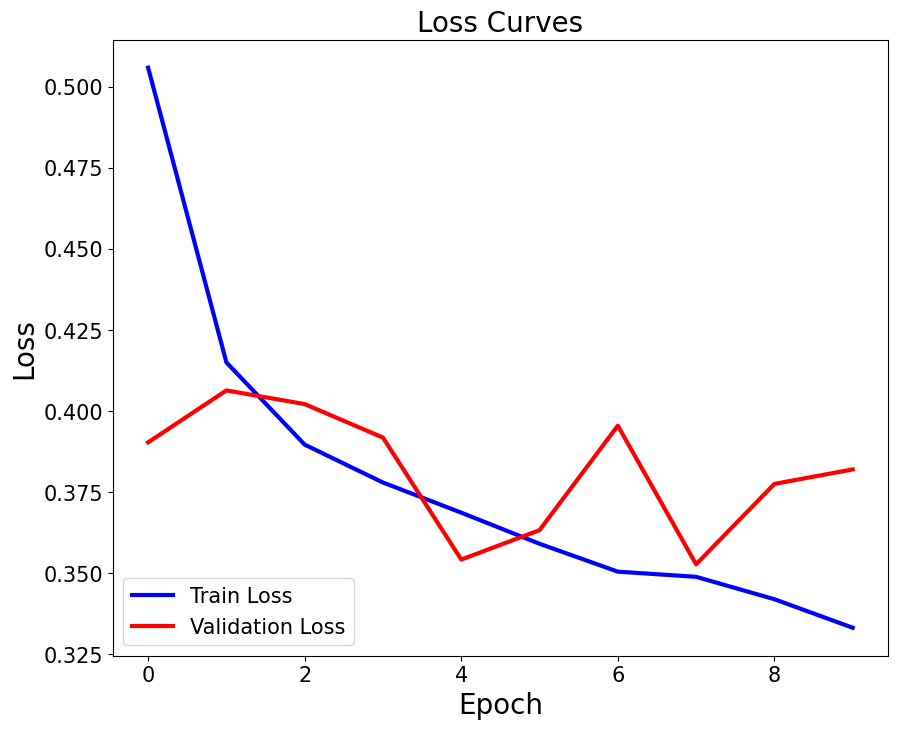

In [62]:
plt.figure(figsize=(10,8))
plt.plot(range(10), hist[3].history['loss'], color='blue', lw=3, label = 'Train Loss')
plt.plot(range(10), hist[3].history['val_loss'], color='red', lw=3,  label = 'Validation Loss')
plt.xlabel('Epoch', fontsize=20)
plt.ylabel('Loss', fontsize=20)
plt.title('Loss Curves', fontsize=20)
plt.legend(loc="lower left", fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

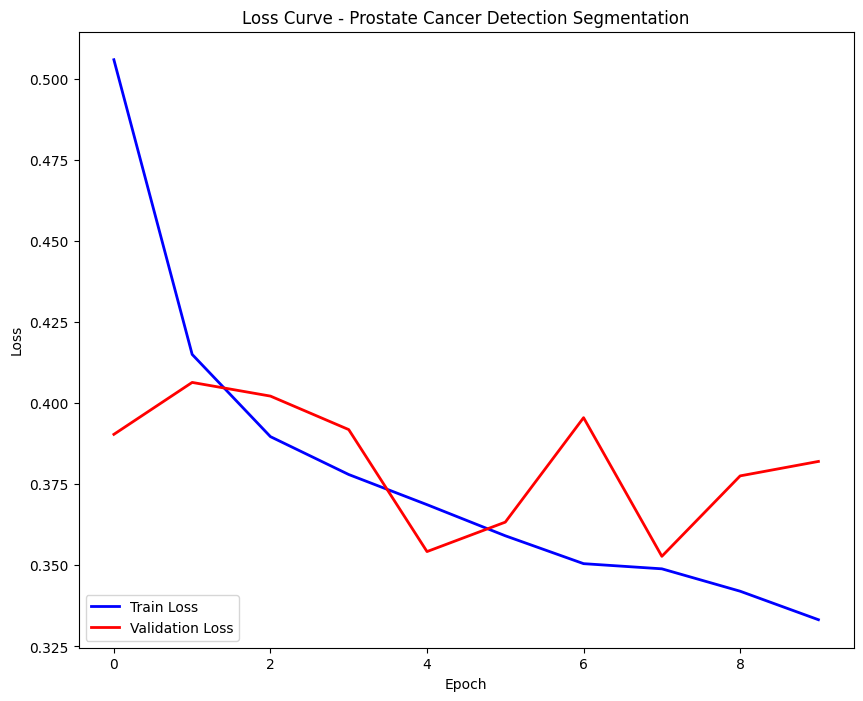

In [63]:
plt.figure(figsize=(10,8))
plt.plot(range(10), hist[3].history['loss'], color='blue', lw=2, label = 'Train Loss')
plt.plot(range(10), hist[3].history['val_loss'], color='red', lw=2,  label = 'Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Curve - Prostate Cancer Detection Segmentation')
plt.legend(loc="lower left")

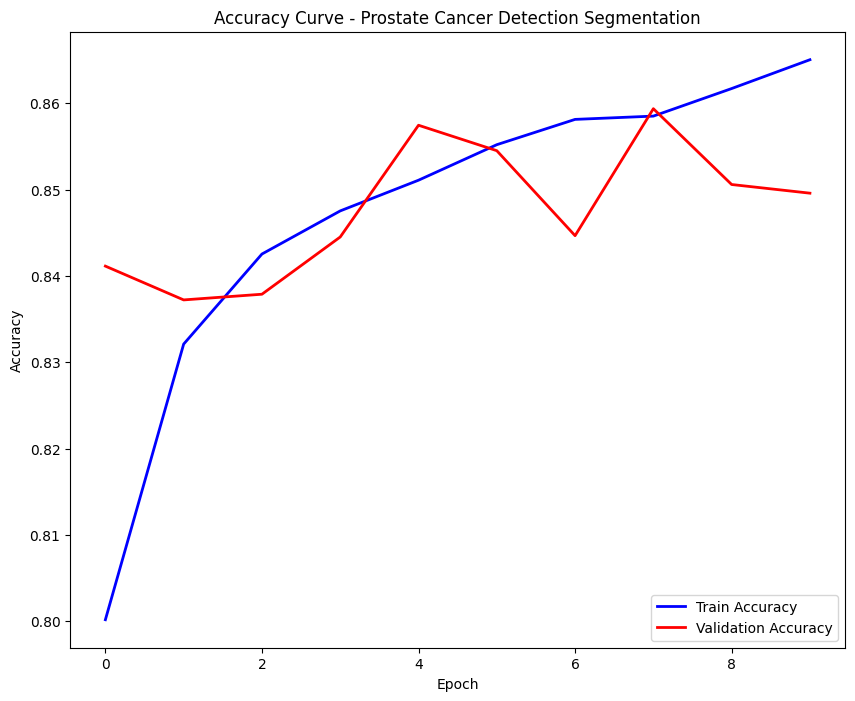

In [64]:
plt.figure(figsize=(10,8))
plt.plot(range(10), hist[3].history['accuracy'], color='blue', lw=2, label = 'Train Accuracy')
plt.plot(range(10), hist[3].history['val_accuracy'], color='red', lw=2,  label = 'Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy Curve - Prostate Cancer Detection Segmentation')
plt.legend(loc="lower right")

In [66]:
with open("/scratch/c.c23115040/models_tr_canc_segm_fluor", "wb") as dill_file: 
    dill.dump(models, dill_file)